# Create Stock Price Indicator Dashboard in Power BI


- toc:true- branch: master- badges: true- comments: true
- author: Ijeoma Odoko
- categories: [python, power bi, jupyter]

## About

The purpose of this project is to create a dataframe capturing stock price data and calculating indicator values using Python, and then visualize it in Power BI in a simple dashboard. 

Key steps taken include: 
1. Create the virtual environment for Windows in Anaconda. 
2. Download the required libraries, and the stock price and volume data from yahoo finance using the pandas_datareader python API into a pandas dataframe. 
3. Calculate the stock indicator values using the TA-lib Python library. Use the Pandas Library if function not available in TA-lib.
4. Convert the dataframe(s) to csv files to use in Power BI.
5. Create dashboard with the indicator values in Power BI.

## Step 1: Create the Virtual Environment for Windows in Anaconda 

Create a new python 3.7 environment in Anaconda. Reference this [cheatsheet.](https://docs.conda.io/projects/conda/en/4.6.0/_downloads/52a95608c49671267e40c689e0bc00ca/conda-cheatsheet.pdf)


Download the TA-Lib wrapper from [here.](https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib) To choose the right one you need to know the python version in your environment, and computer's operating system (32bit or 64bit).

Move it to the same Computer path that shows on your Anaconda Powershell prompt for your new virtual environment.

Run pip install with the TA-Lib file name, see picture below.

Pip Install all other required libraries like pandas, datetime, pandas_datareader.



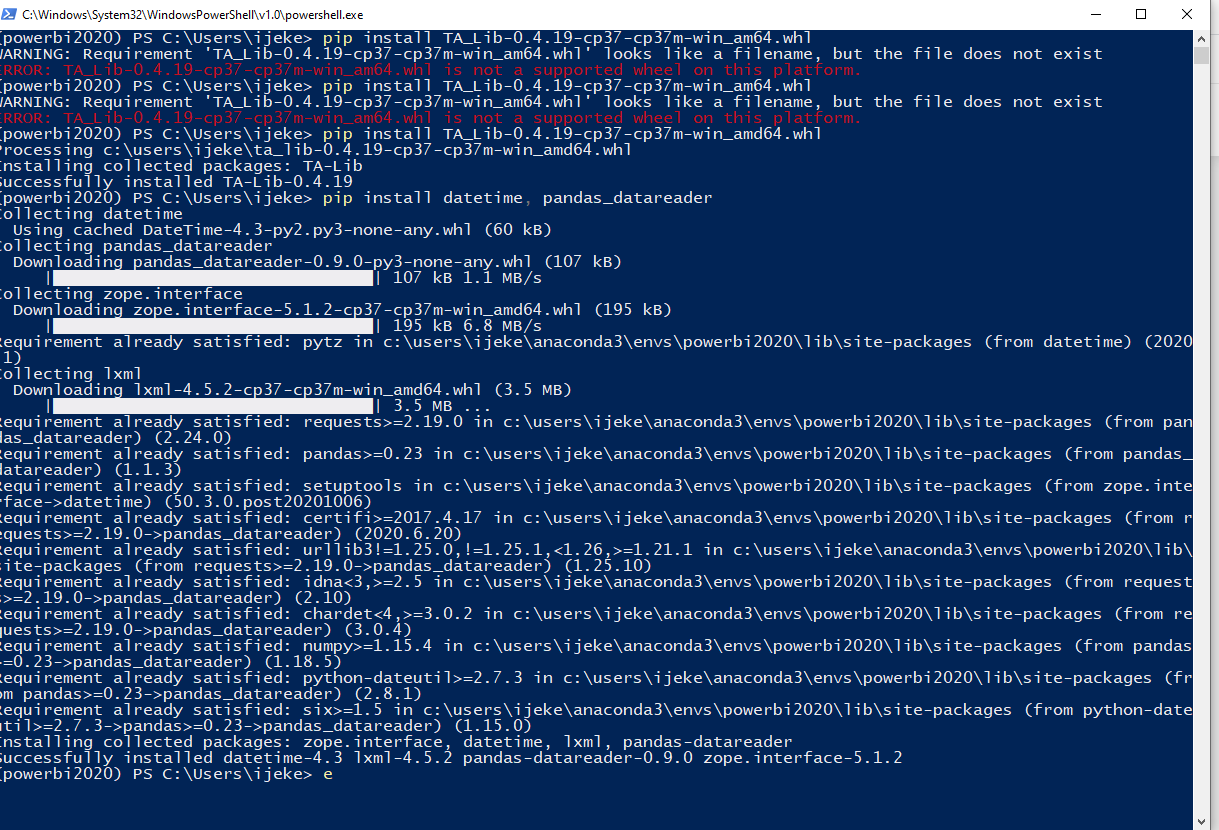

## Step 2: Download required python libraries and data from Yahoo Finance

In [1]:
# import python libraries
from pandas_datareader import data
import numpy as np
from datetime import datetime 
from datetime import date, timedelta
import pandas as pd
import talib

In [2]:
# Create Parameters 
Number_of_days = input('Enter Calendar days:')
print(Number_of_days)

Stock_Ticker = input('Enter Stock Ticker:') 
print(Stock_Ticker)

Moving_Average = input('Enter Bollinger Bands Moving Average Type (Simple or Exponential): ')
if Moving_Average == 'Simple':
    print(Moving_Average)
elif Moving_Average == 'Exponential':
    print(Moving_Average)
else: 
    print('error')

Days = int(Number_of_days)


Enter Calendar days:740
740
Enter Stock Ticker:TQQQ
TQQQ
Enter Bollinger Bands Moving Average Type (Simple or Exponential): Simple
Simple


In [3]:
# load stock data from yahoo 

start = date.today() - timedelta(Days)
today = date.today()
df = data.DataReader(Stock_Ticker, start=start, end=today,
                       data_source='yahoo')

## Step 3: Create stock indicator values using Pandas and TA-lib library

In [4]:
# ADD INDICATORS TO MAIN DATAFRAME df

df['Daily_Returns'] = df['Adj Close'].pct_change()  # create column for daily returns
df['Price_Up_or_Down'] = np.where(df['Daily_Returns'] < 0, -1, 1) # create column for price up or down

## add columns for the volatility and volume indicators
from talib import ATR, OBV, ADX, RSI
df['Average_True_Range'] = ATR(df['High'], df['Low'], df['Close'])
df['On_Balance_Volume'] = OBV(df['Adj Close'], df['Volume'])

## add columns for momentum indicators
from talib import ADX, RSI, STOCH, WILLR, MFI
df['ADX'] = ADX(df['High'], df['Low'], df['Close'], timeperiod=14) #create column for ADX assume timeperiod of 14 days
df['RSI'] = RSI(df['Adj Close'],timeperiod=14) #create column for RSI assume timeperiod of 14 days 
df['William_%R'] = WILLR(df['High'],df['Low'], df['Close'], timeperiod=14) #create column for William %R use high, low and close, and assume timeperiod of 14 days
df['MFI'] = MFI(df['High'],df['Low'], df['Close'], df['Volume'], timeperiod=14) #create column for MFI use high, low and close, and assume timeperiod of 14 days

## add columns for statistic functions
from talib import LINEARREG, TSF

adj_close = df['Adj Close'].to_numpy()  # create ndarray from the adj_close prices

df['Linear_Regression'] = LINEARREG(adj_close, timeperiod=14)
df['Time_Series_Forecast'] = TSF(adj_close, timeperiod=14)

## add column for moving averages
from talib import MA, SMA, EMA, WMA    #import the moving average functions
df['Simple_Moving_Average_50'] = SMA(df['Adj Close'], timeperiod=50)
df['Simple_Moving_Average_200'] = SMA(df['Adj Close'], timeperiod=200)
    
## add columns for momentum indicators STOCH_df
slowk, slowd = STOCH(df['High'], df['Low'], df['Close'], fastk_period= 5, slowk_period= 3, slowk_matype= 0, slowd_period = 3, slowd_matype = 0) # uses high, low, close by default
STOCH_array = np.array([slowk, slowd]).transpose() 
STOCH_df = pd.DataFrame(data = STOCH_array, index=df.index, columns=['STOCH_slowk', 'STOCH_slowd'])

df = STOCH_df[['STOCH_slowk', 'STOCH_slowd']].join(df, how='right')  # join STOCH to main dataframe 



# CREATE Bollinger Bands® DATAFRAME WITH Bollinger Bands® INDICATORS

from talib import BBANDS

## Parameters
BBands_periods = 20
SDnumber = 2

if Moving_Average == 'Simple': 
    moving_avg= 0
    
else:
    moving_avg = 1    
 
upperband, middleband, lowerband = BBANDS(adj_close, timeperiod=BBands_periods, nbdevup=SDnumber, nbdevdn = SDnumber, matype=moving_avg)  # calculate the bollinger bands assuming the middle band as the simple moving average

bands = np.array([upperband, middleband, lowerband]).transpose()  # transpose the ndarrays 

stocks_bollingerbands = pd.DataFrame(data = bands, index = df.index, columns=['BB_upperband', 'BB_middleband', 'BB_lowerband']) # create dataframe from the ndarrays

stocks_bollingerbands = df[['Adj Close']].join(stocks_bollingerbands, how='left')  # add Adj Close Column and volume to bollinger bands dataframe 

stocks_bollingerbands['BB_Width'] = (stocks_bollingerbands['BB_upperband'] - stocks_bollingerbands['BB_lowerband']).div(stocks_bollingerbands['BB_middleband']) # add column for Bollinger Band Width

stocks_bollingerbands['Percent_B'] = (stocks_bollingerbands['Adj Close'] - stocks_bollingerbands['BB_lowerband']).div(stocks_bollingerbands['BB_upperband'] - stocks_bollingerbands['BB_lowerband']).mul(100) # add column for Percent B

## create list for Bollinger Bands® buy/sell strategy conditions
buy_or_sell = [
    (stocks_bollingerbands['Adj Close'] > stocks_bollingerbands['BB_upperband']),
    (stocks_bollingerbands['Adj Close'] <  stocks_bollingerbands['BB_lowerband'])
    ]

choices = ['Sell', 'Buy']

stocks_bollingerbands['Action'] = np.select(buy_or_sell, choices, default = 'Neutral') # create new column for action to take based on BollingerBand values

stocks_bollingerbands.drop(columns='Adj Close', inplace=True)  # drop Adj Close column

stocks_bollingerbands.dropna(inplace=True) # drop empty rows


# CREATE MERGED DATAFRAME

# join Bollinger Bands® dataframe to main dataframe to create new

stocks_df = stocks_bollingerbands.join(df, how='left')   
stocks_df

,BB_upperband,BB_middleband,BB_lowerband,BB_Width,Percent_B,Action,STOCH_slowk,STOCH_slowd,High,Low,...,Average_True_Range,On_Balance_Volume,ADX,RSI,William_%R,MFI,Linear_Regression,Time_Series_Forecast,Simple_Moving_Average_50,Simple_Moving_Average_200
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-30,70.023204,57.441679,44.860155,0.438063,15.693175,Neutral,27.900666,27.639096,49.049999,45.570000,...,5.123637,-1.397404e+08,NaN,31.158793,-71.739130,32.891829,49.628769,48.881414,NaN,NaN
2018-10-31,67.553510,56.486655,45.419801,0.391840,30.191152,Neutral,46.609921,35.213573,53.660000,51.250000,...,5.096948,-1.172207e+08,NaN,36.433929,-53.344484,41.639084,48.860358,48.009042,NaN,NaN
2018-11-01,65.799976,55.848475,45.896975,0.356375,42.609367,Neutral,71.598957,48.703181,54.619999,51.439999,...,4.960023,-1.014624e+08,NaN,39.862677,-40.635438,40.177119,49.358470,48.622607,NaN,NaN
2018-11-02,64.439876,55.214786,45.989696,0.334153,32.264480,Neutral,83.134317,67.114398,54.930000,50.799999,...,4.900736,-1.232571e+08,NaN,37.529625,-54.236345,40.113450,49.019171,48.272671,NaN,NaN
2018-11-05,63.153036,54.613530,46.074023,0.312725,31.381121,Neutral,78.868933,77.867402,52.139999,49.759998,...,4.720684,-1.360822e+08,NaN,37.041639,-57.079145,34.302688,49.342788,48.745978,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-06,138.348875,125.399501,112.450128,0.206530,54.172024,Neutral,31.246967,50.686292,135.119995,125.150002,...,9.713780,1.352882e+09,20.178407,48.428622,-38.672007,42.728684,132.350001,133.575605,131.548601,95.623291
2020-10-07,138.518796,125.452501,112.386207,0.208307,79.379039,Neutral,49.199414,46.141732,134.110001,129.380005,...,9.564938,1.381018e+09,19.732322,52.268168,-16.483153,49.831451,134.138573,135.507804,132.055401,95.863445
2020-10-08,139.695310,125.985501,112.275692,0.217641,83.204312,Neutral,55.772146,45.406176,136.610001,133.539993,...,9.130299,1.405755e+09,18.965605,53.370095,-9.943310,57.363264,135.420572,136.782528,132.528001,96.110250


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 510 entries, 2018-10-03 to 2020-10-12
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   STOCH_slowk                502 non-null    float64
 1   STOCH_slowd                502 non-null    float64
 2   High                       510 non-null    float64
 3   Low                        510 non-null    float64
 4   Open                       510 non-null    float64
 5   Close                      510 non-null    float64
 6   Volume                     510 non-null    float64
 7   Adj Close                  510 non-null    float64
 8   Daily_Returns              509 non-null    float64
 9   Price_Up_or_Down           510 non-null    int32  
 10  Average_True_Range         496 non-null    float64
 11  On_Balance_Volume          510 non-null    float64
 12  ADX                        483 non-null    float64
 13  RSI                        496 

In [6]:
stocks_bollingerbands.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 491 entries, 2018-10-30 to 2020-10-12
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BB_upperband   491 non-null    float64
 1   BB_middleband  491 non-null    float64
 2   BB_lowerband   491 non-null    float64
 3   BB_Width       491 non-null    float64
 4   Percent_B      491 non-null    float64
 5   Action         491 non-null    object 
dtypes: float64(5), object(1)
memory usage: 46.9+ KB


In [7]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 491 entries, 2018-10-30 to 2020-10-12
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BB_upperband               491 non-null    float64
 1   BB_middleband              491 non-null    float64
 2   BB_lowerband               491 non-null    float64
 3   BB_Width                   491 non-null    float64
 4   Percent_B                  491 non-null    float64
 5   Action                     491 non-null    object 
 6   STOCH_slowk                491 non-null    float64
 7   STOCH_slowd                491 non-null    float64
 8   High                       491 non-null    float64
 9   Low                        491 non-null    float64
 10  Open                       491 non-null    float64
 11  Close                      491 non-null    float64
 12  Volume                     491 non-null    float64
 13  Adj Close                  491 

## Step 4: Download dataframes to csv



Power BI only supports the following python packages: [source](https://powerbi.microsoft.com/en-us/blog/python-visualizations-in-power-bi-service/)

  
  *matplotlib*
  
  *numpy*
  
  *pandas*
  
  *scikit-learn*
  
  *scipy*
  
  *seaborn*
  
  *statsmodels*

In [8]:
## send to CSV file

df.to_csv(r"C:\TQQQ_df.csv", sep = ',')
stocks_bollingerbands.to_csv(r"C:\TQQQ_bbands.csv", sep=',')


## Step 5: Create visual dashboard in Power BI using the dataframes 

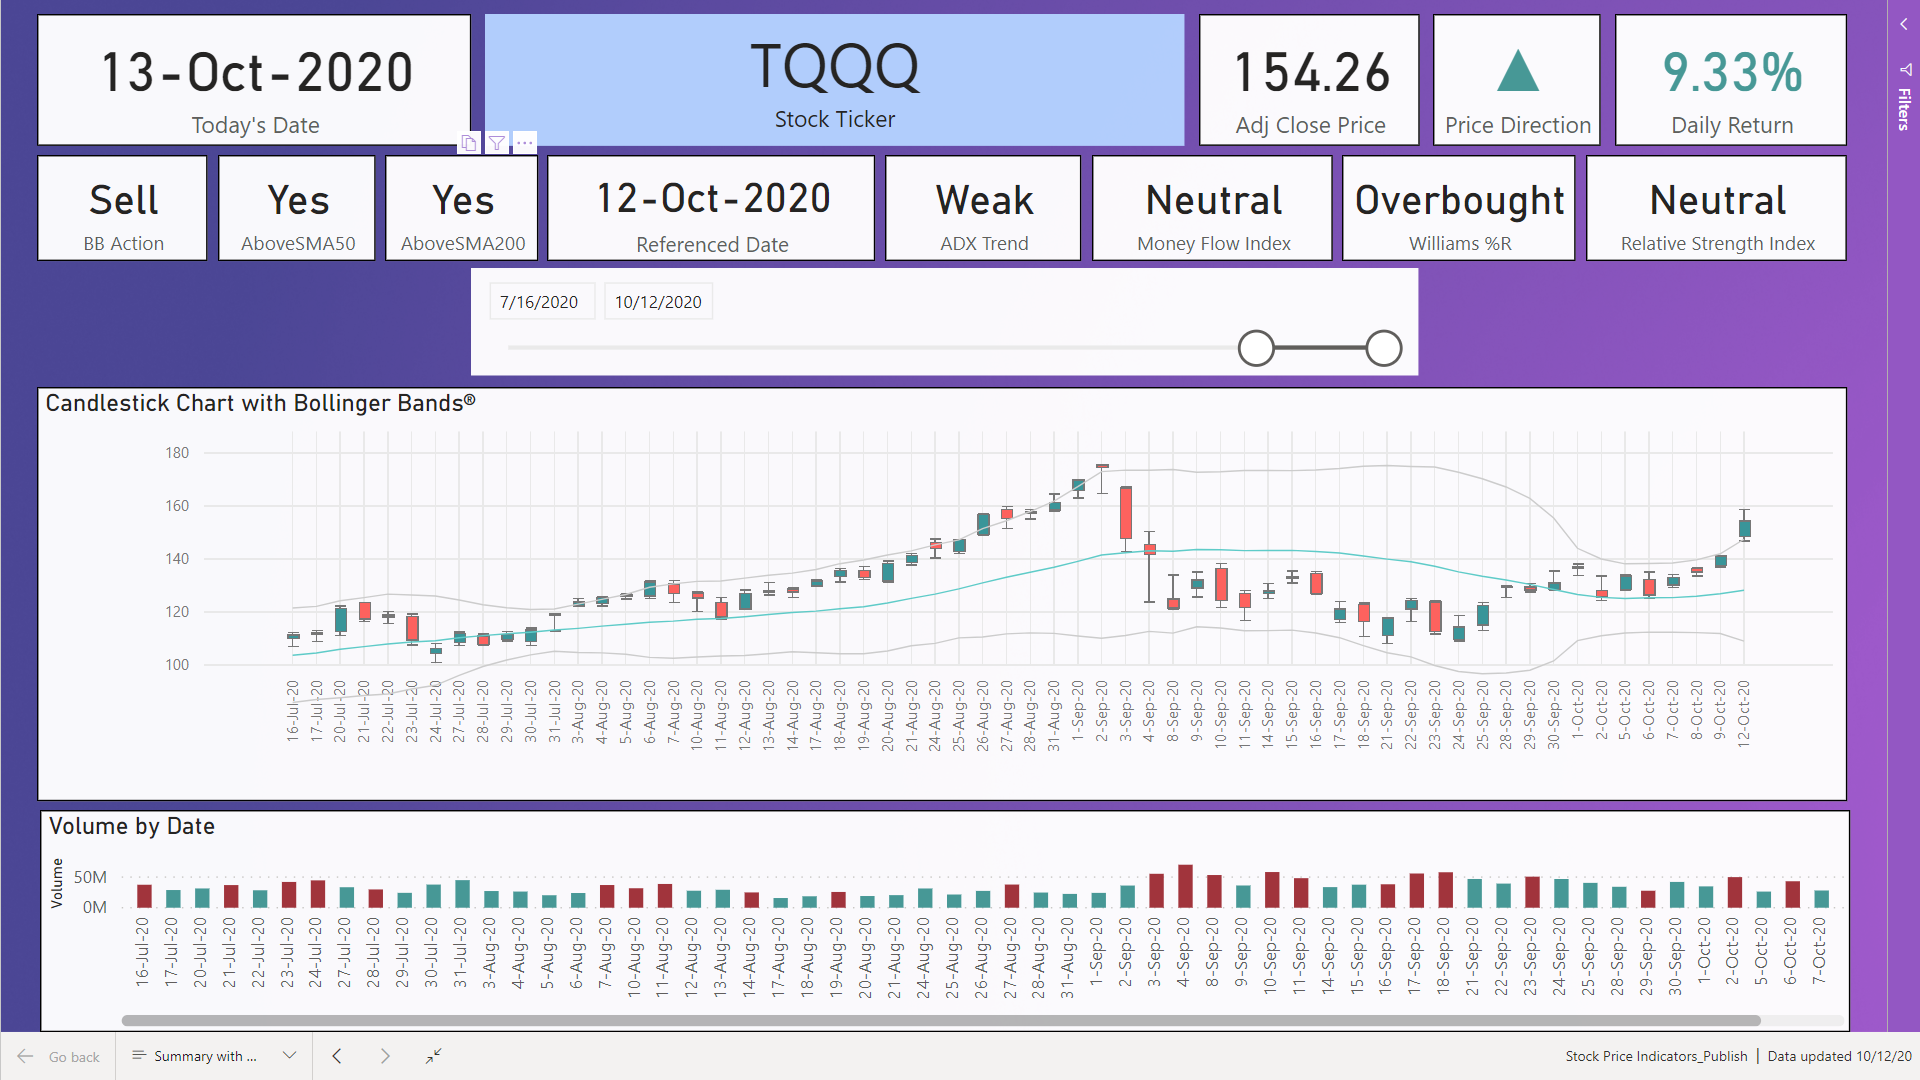

## References

[Fidelity, Percent B (% B).](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/percent-b#:~:text=How%20this%20indicator%20works,Percent%20B%20is%2050%20percent.) Accessed October 1, 2020.

[Fidelity, Bollinger Band® Width.](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/bollinger-band-width) Accessed October 1, 2020.

[Fidelity, Bollinger Bands®.](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/bollinger-bands) Accessed October 1, 2020.

[TA-lib python library.](https://github.com/mrjbq7/ta-lib) Accessed October 1, 2020.

[Williams %R.](https://school.stockcharts.com/doku.php?id=technical_indicators:williams_r) Accessed October 9, 2020

[Money Flow Index](https://www.investopedia.com/terms/m/mfi.asp)Accessed October 9, 2020.

[Relative Strength Index](https://www.investopedia.com/terms/r/rsi.asp)Accessed October 9, 2020.

[ADX: The Trend Strength Indicator](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp)Accessed October 9, 2020.

[Bollinger Bands Rules.](https://www.bollingerbands.com/bollinger-band-rules) Accessed October 1, 2020.

